In [1]:
import sys 
sys.path.append('..')
from LRL import *

In [2]:
USE_CUDA

True

# Cartpole task

In [3]:
env = gym.make('CartPole-v0')

In [4]:
class CartpoleNN(nn.Module):
    def __init__(self, linear):
        super().__init__()
        
        self.layers = nn.Sequential(
                        linear(4, 128),
                        nn.ReLU(),
                        linear(128, 128),
                        nn.ReLU())
        
    def forward(self, x):
        return self.layers(x)

# Store experiment results

In [5]:
import time
import pandas as pd
results = pd.DataFrame(columns=["Reached 200", "Average reward", "FPS"])

In [6]:
def store_res(name, agent):
    perfect = np.nonzero(np.array(agent.logger["rewards"]) == 200)[0]
    
    results.loc[name] = [perfect[0] if len(perfect) > 0 else None,
                         np.array(agent.logger["rewards"]).mean(),
                         np.median(agent.logger["fps"])]

## Smooth Q-learning

In [7]:
def Smooth(parclass):
    """Requires parent class, inherited from Agent."""

    class Smooth(parclass):
        """
        Experimental.
        """
        __doc__ += parclass.__doc__ 

        def optimize_model(self):
            '''One step of Q-network optimization'''        
            self.batch = self.sample(self.config.batch_size)
            state_b, action_b, reward_b, next_state_b, done_b, weights_b = self.batch
            # TODO: weights logging?

            state_b      = Tensor(np.float32(state_b))
            next_state_b = Tensor(np.float32(next_state_b))
            action_b     = self.ActionTensor(action_b)
            reward_b     = Tensor(np.float32(reward_b))
            done_b       = Tensor(np.float32(done_b))
            weights_b    = Tensor(weights_b)

            # optimizing forward pass through net!
            self.q_net.train()
            output = self.q_net(torch.cat([state_b, next_state_b], dim=0))
            self.state_q, self.next_state_q = torch.split(output, self.config.batch_size, dim=0)

            # getting q values for state and next state
            q_values = self.q_net.gather(self.state_q, action_b)
            result = q_values - (1 - 0.5) * (self.config.gamma**self.config.replay_buffer_nsteps) * \
                                            (1 - done_b) * self.next_state_q.max(dim=1)[0]
            wish = (0.5 * q_values + (1 - 0.5) * reward_b).detach()

            # getting loss and updating transition importances
            loss_b = self.get_loss(wish, result)
            self.update_priorities(self.get_transition_importance(loss_b).detach().cpu().numpy())

            assert len(loss_b.shape) == 1, loss_b

            # making optimization step
            loss = (loss_b * weights_b).mean()
            self.logger["loss"].append(loss.detach().cpu().numpy())

            self.q_net.optimize(loss)
    return Smooth

In [13]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": CartpoleNN,
    "QnetworkHead": Qnetwork,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_init": 128,
    "replay_buffer_capacity": 1000,
    "epsilon_start": 1, "epsilon_final": 0.01, "epsilon_decay": 500
}

In [14]:
agent = eGreedy(Smooth(QAgent(ReplayBufferAgent)))(config)

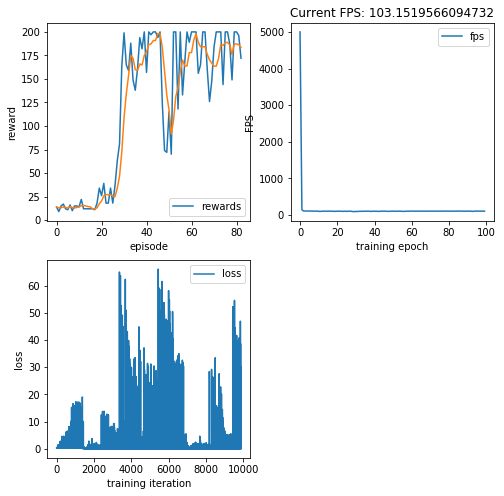

In [15]:
for i in range(100):
    agent.learn(100)
    plot_durations(agent, 5)    

plt.show()

In [16]:
store_res("Smooth DQN", agent)

## Smooth Backwards DQN

In [18]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": CartpoleNN,
    "QnetworkHead": Qnetwork,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_init": 128,
    "replay_buffer_games_capacity": 50,
    "epsilon_start": 1, "epsilon_final": 0.01, "epsilon_decay": 500
}

In [19]:
agent = eGreedy(Smooth(QAgent(BackwardBufferAgent)))(config)

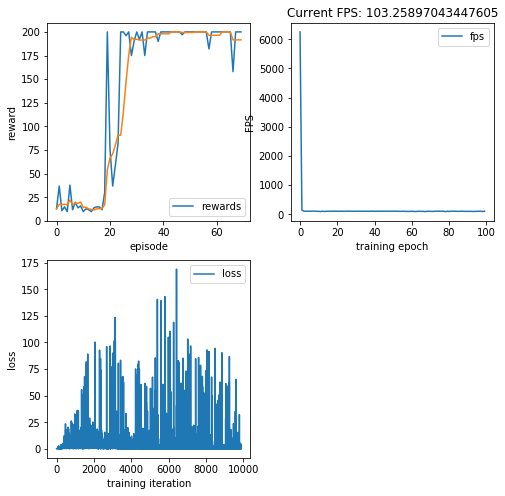

In [20]:
for i in range(100):
    agent.learn(100)
    plot_durations(agent, 5)    

plt.show()

In [21]:
store_res("Smooth backward DQN", agent)

## Double DQN

In [22]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": CartpoleNN,
    "QnetworkHead": Qnetwork,
    "target_update": 100,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_init": 128,
    "replay_buffer_capacity": 1000,
    "epsilon_start": 1, "epsilon_final": 0.01, "epsilon_decay": 500
}

In [23]:
agent = eGreedy(DoubleQAgent(QAgent(ReplayBufferAgent)))(config)

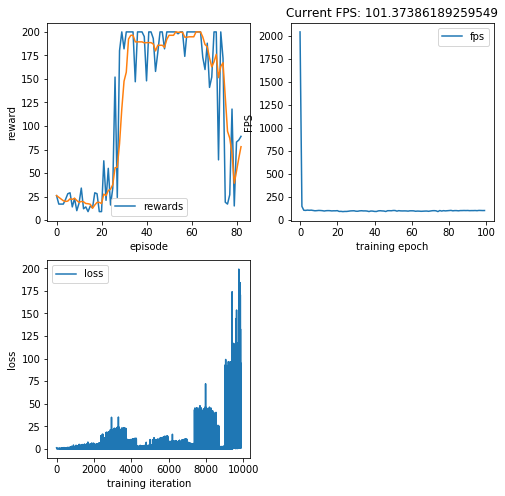

In [24]:
for i in range(100):
    agent.learn(100)
    plot_durations(agent, 5)    

plt.show()

In [25]:
store_res("Double DQN", agent)

## Double DQN + Prioritized

In [32]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": CartpoleNN,
    "QnetworkHead": Qnetwork,
    "target_update": 100,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_init": 128,
    "replay_buffer_capacity": 1000,
    "epsilon_start": 1, "epsilon_final": 0.01, "epsilon_decay": 500,
    "rp_alpha": 0.6, "rp_beta_start": 0.4, "rp_beta_frames": 100
}

In [33]:
agent = eGreedy(DoubleQAgent(QAgent(PrioritizedBufferAgent)))(config)

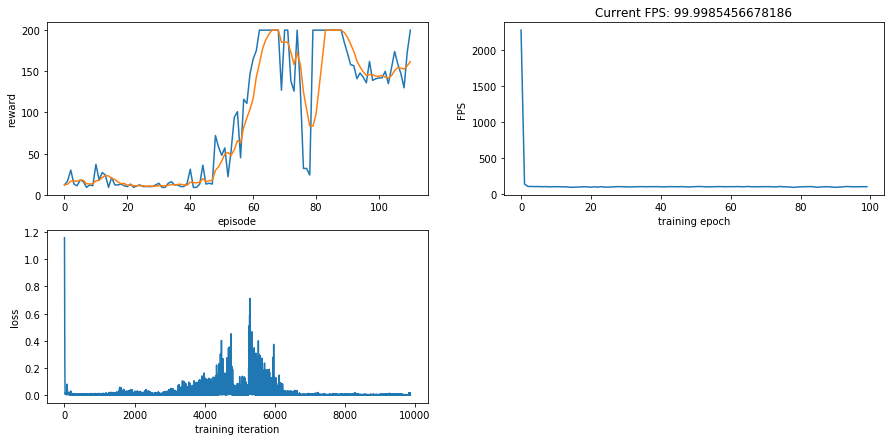

In [34]:
for i in range(100):
    agent.learn(100)
    plot_durations(agent, 5)    

plt.show()

In [35]:
store_res("Prioritized Double DQN", agent)

# Categorical

In [52]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": CartpoleNN,
    "QnetworkHead": CategoricalQnetwork,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_init": 128,
    "replay_buffer_capacity": 1000,
    "epsilon_start": 1, "epsilon_final": 0.01, "epsilon_decay": 500,
    "Vmin": -10, "Vmax": 10, "num_atoms": 51
}

In [53]:
agent = eGreedy(CategoricalQAgent(ReplayBufferAgent))(config)

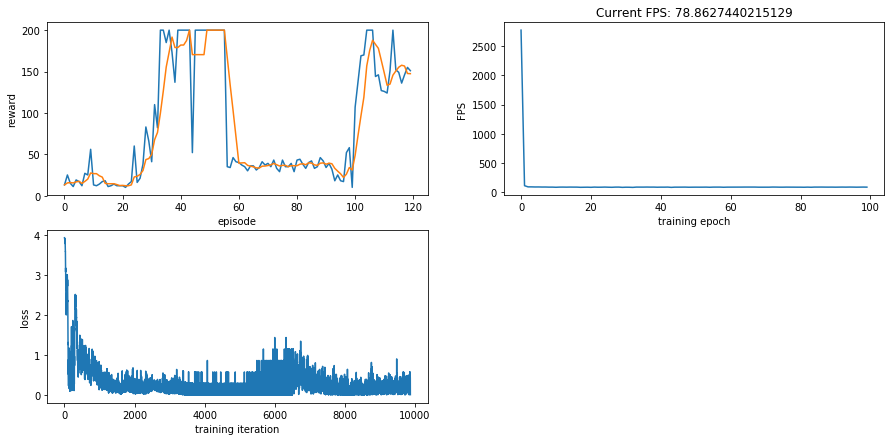

In [54]:
for i in range(100):
    agent.learn(100)
    plot_durations(agent, 5)    

plt.show()

In [55]:
store_res("Categorical DQN", agent)

# Categorical Backwards

In [56]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": CartpoleNN,
    "QnetworkHead": CategoricalQnetwork,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_init": 128,
    "replay_buffer_games_capacity": 50,
    "epsilon_start": 1, "epsilon_final": 0.01, "epsilon_decay": 500,
    "Vmin": -10, "Vmax": 10, "num_atoms": 51
}

In [57]:
agent = eGreedy(CategoricalQAgent(BackwardBufferAgent))(config)

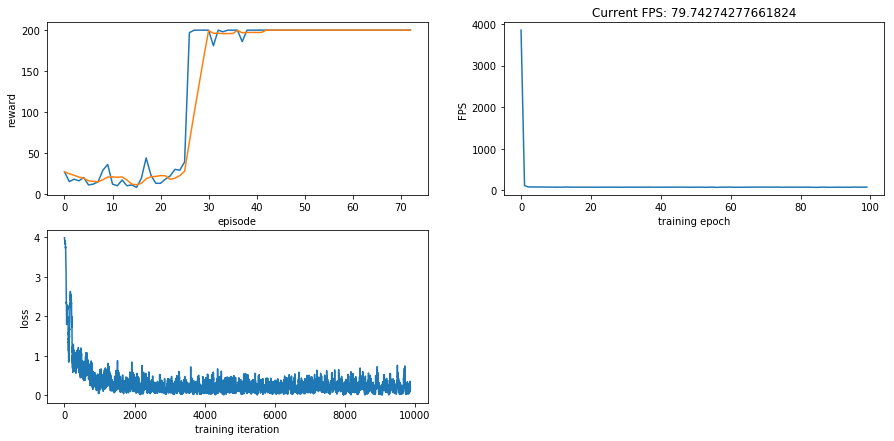

In [58]:
for i in range(100):
    agent.learn(100)
    plot_durations(agent, 5)    

plt.show()

In [59]:
store_res("Categorical Backwards DQN", agent)

# QR-DQN

In [7]:
config = {
    "env": env,
    "Qnetwork_FeatureExtractor": CartpoleNN,
    "batch_size": 32,
    "gamma": 0.99,
    "replay_buffer_init": 128,
    "replay_buffer_capacity": 1000,
    "epsilon_start": 1, "epsilon_final": 0.01, "epsilon_decay": 500,
    "quantiles": 51
}

In [8]:
agent = eGreedy(DoubleQAgent(QuantileQAgent(ReplayBufferAgent)))(config)

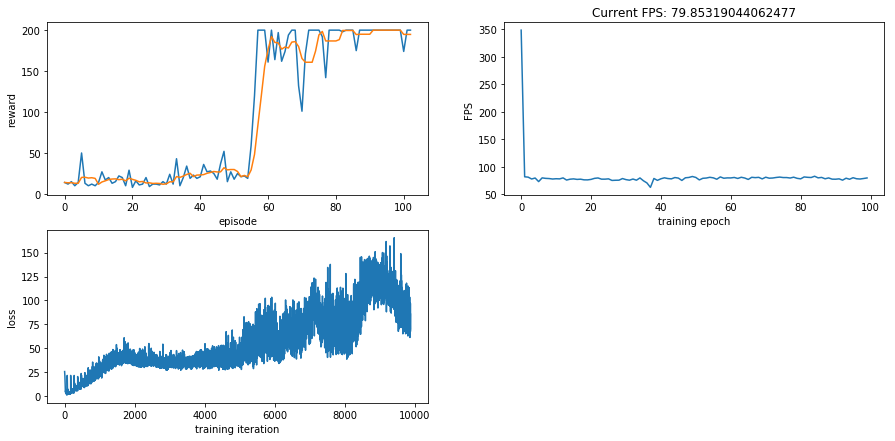

In [9]:
for i in range(100):
    agent.learn(100)
    plot_durations(agent, 5)    

plt.show()

In [55]:
store_res("Quantile DQN", agent)

# RESULTS

In [26]:
results

,Reached 200,Average reward,FPS
Smooth DQN,39.0,119.566261,103.294650
Smooth backward DQN,19.0,140.371429,103.257877
Double DQN,29.0,120.433739,98.287533


In [84]:
results # from "Playing with cartpole" and backwards experiments

,Reached 200,Average reward,FPS
Backward DQN,50.0,103.589470,102.609290
Pure backward DQN,58.0,102.822914,110.712171
DQN,45.0,101.958763,102.549885
Double DQN,30.0,105.147369,100.637534
Dueling Double DQN,34.0,120.256096,70.079083
Prioritized Double DQN,62.0,89.720718,99.884073
Noisy Double DQN,NaN,9.333333,43.103519
Noisy Prioritized Double DQN,132.0,55.297752,41.839491
Noisy Prioritized Dueling Double DQN,NaN,9.365511,30.855807
Categorical DQN,33.0,82.791664,79.121614


In [64]:
env.close()